In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import pathlib

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
print(tf.__version__)


2.4.1


In [4]:
data_dir = pathlib.Path("/home/divyanshu/Documents/Datasets/catvsdog/training_set")

In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

8005


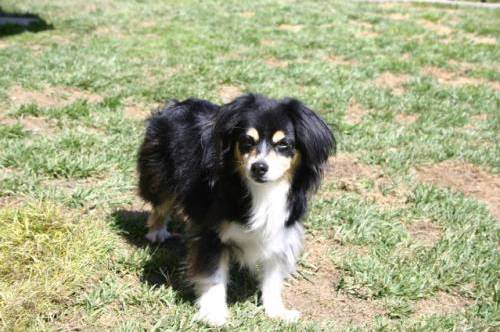

In [6]:
dogs = list(data_dir.glob('dogs/*'))
PIL.Image.open(str(dogs[0]))


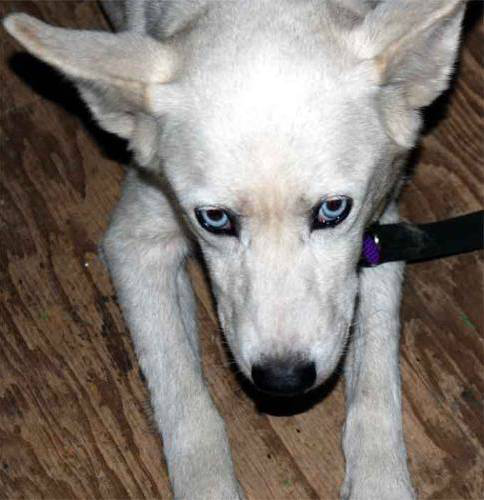

In [7]:
PIL.Image.open(str(dogs[1]))

In [8]:
batch_size = 32
img_height = 96
img_width = 96

In [9]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8005 files belonging to 2 classes.
Using 6404 files for training.


In [10]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8005 files belonging to 2 classes.
Using 1601 files for validation.


In [11]:
class_names = train_ds.class_names
print(class_names)


['cats', 'dogs']


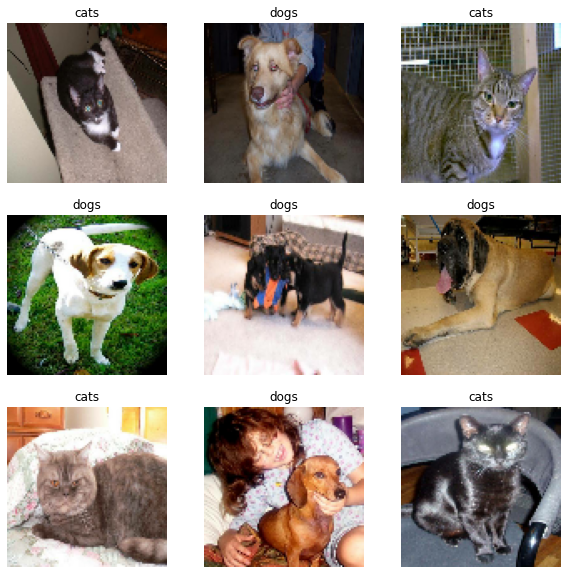

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


In [13]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break


(32, 96, 96, 3)
(32,)


In [14]:
from tensorflow.keras import layers
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [15]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [16]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [17]:
IMG_SHAPE = (img_height,img_width) + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [18]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)


(32, 3, 3, 1280)


In [19]:
base_model.trainable = False


In [20]:
base_model.summary()

xpand_relu[0][0]        
__________________________________________________________________________________________________
block_6_depthwise (DepthwiseCon (None, 6, 6, 192)    1728        block_6_pad[0][0]                
__________________________________________________________________________________________________
block_6_depthwise_BN (BatchNorm (None, 6, 6, 192)    768         block_6_depthwise[0][0]          
__________________________________________________________________________________________________
block_6_depthwise_relu (ReLU)   (None, 6, 6, 192)    0           block_6_depthwise_BN[0][0]       
__________________________________________________________________________________________________
block_6_project (Conv2D)        (None, 6, 6, 64)     12288       block_6_depthwise_relu[0][0]     
__________________________________________________________________________________________________
block_6_project_BN (BatchNormal (None, 6, 6, 64)     256         block_6_project[0][

In [21]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [22]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [23]:
inputs = tf.keras.Input(shape=(96, 96, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [24]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [25]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 96, 96, 3)         0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 96, 96, 3)         0         
_________________________________________________________________
mobilenetv2_1.00_96 (Functio (None, 3, 3, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281  

In [26]:
len(model.trainable_variables)

2

In [27]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(val_ds)

51/51 [==============================] - 51s 688ms/step - loss: 0.9485 - accuracy: 0.4521


In [28]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.98
initial accuracy: 0.43


In [29]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/10
201/201 [==============================] - 135s 658ms/step - loss: 0.5962 - accuracy: 0.6521 - val_loss: 0.3383 - val_accuracy: 0.8501
Epoch 2/10
201/201 [==============================] - 21s 107ms/step - loss: 0.2839 - accuracy: 0.8724 - val_loss: 0.2158 - val_accuracy: 0.9144
Epoch 3/10
201/201 [==============================] - 21s 106ms/step - loss: 0.2025 - accuracy: 0.9168 - val_loss: 0.1736 - val_accuracy: 0.9325
Epoch 4/10
201/201 [==============================] - 22s 108ms/step - loss: 0.1710 - accuracy: 0.9297 - val_loss: 0.1528 - val_accuracy: 0.9388
Epoch 5/10
201/201 [==============================] - 21s 106ms/step - loss: 0.1483 - accuracy: 0.9405 - val_loss: 0.1406 - val_accuracy: 0.9450
Epoch 6/10
201/201 [==============================] - 22s 108ms/step - loss: 0.1389 - accuracy: 0.9435 - val_loss: 0.1326 - val_accuracy: 0.9482
Epoch 7/10
201/201 [==============================] - 22s 108ms/step - loss: 0.1326 - accuracy: 0.9461 - val_loss: 0.1265 - val_a

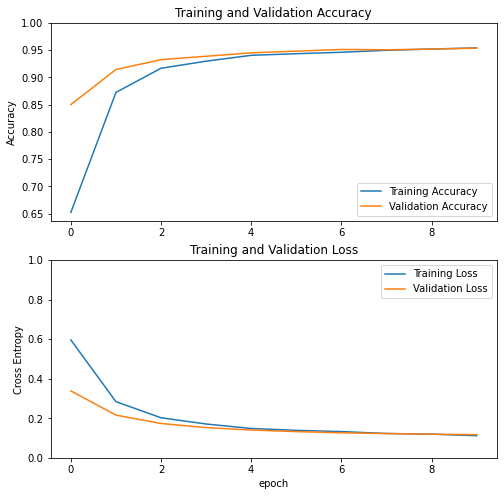

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [31]:
test_dir= pathlib.Path("/home/divyanshu/Documents/Datasets/catvsdog/test_set")

In [32]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2023 files belonging to 2 classes.


In [33]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

64/64 [==============================] - 24s 380ms/step - loss: 0.1139 - accuracy: 0.9540
Test accuracy : 0.9540286660194397


Predictions:
 [0 0 1 1 1 1 1 1 1 1 1 0 1 1 0 1 0 1 1 0 0 0 0 0 0 0 0 0 1 0 1 1]
Labels:
 [0 0 1 1 1 1 1 1 1 1 1 0 1 1 0 1 0 1 1 0 0 0 0 0 0 0 0 0 1 0 1 1]


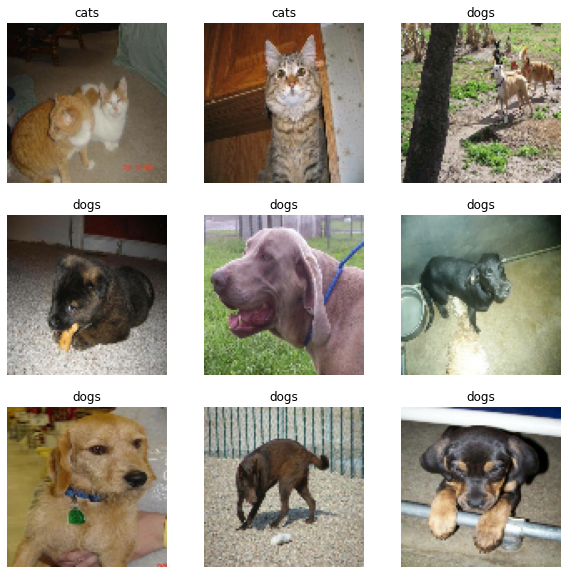

In [34]:
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")
